<img align="center" width="800" src="./Material/title.png">

# Problem description

We are running a company that produces a particular type of luxury gifts: personalised jewellery with names. These pieces of jewellery are handcrafted.

The production of a given piece of jewellery for a particular name (say "Emma") requires:
  * A set of tasks to produce each individual letters (so "E", "m", "m", "a")
  * A task to assemble all these letters together for producing the final piece of jewellery

The duration for producing a particular letter depends on the letter itself (for instance producing the letter 'm' is more complex than production the letter 'a' so it will take longer [1]). The duration for producing the different letters is given in the data as a table. In the problem, all times are given in minutes (mn). 

The assembly task can be performed only after all the letters have been produced. Its duration is proportional to the number of letters to assemble.

The duration for each letter and the proportionality factor for assembly duration are given in file Data/data.json in JSON format, for instance:

    {
       "assembly" : 500,
       "letters"  : {
          "A": 1443,
          "B": 1841,   
          "C": 1247,
          "D": 1741,
          "E": 1562,
          ...
       }
    }

As an example, the figure below display the process for producing a piece of jewellery for Emma. The arcs represent precedence constraints between tasks. The blue task in the end is the assembly task.

<img align="center" width="300" src="./Material/process.png">

We are on Jan 1, 2021 and our company has collected the set of production orders for the year. A production order is a type of jewellery to produce (so, a name) and a due-date. We assume that all our customers want to have their gift ready for their birthday. Thus a production order is given by a pair (name,birthday). 

Orders are defined in file orders.json in JSON format, for instance:

    { "orders" : [
        ["Emma",  "15/04"],
        ["Emily", "14/01"],
        ...
        ]
    }
    
In the first version of the problem, we suppose that we only have one master jeweller working 24/7 and that the penalty for late delivery of a gift is quadratic: its value is $T^2$ if $T$ denotes the tardiness in days. For instance if the gift for Emma is only available on 18/04 (so 3 days after Emma's birthday), the related tardiness penalty will be $3^2=9$.

We want to schedule the production so as to minimize the total tardiness penalty given that our master jeweller can perform only one task at a time.

# Reading the data

In [1]:
# Reading data file for assembly and letter durations
import json
with open("./Data/data.json") as data_file:
    data = json.load(data_file)
A = data["assembly"]
D = data["letters"]

# Reading production orders
with open("./Data/orders.json") as data_file:
    data = json.load(data_file)
O = data["orders"]
n = len(O)
L = [ [l for l in O[i][0]] for i in range(n) ]

# Displaying orders
print("{:<20} {:<10}".format('NAME','BIRTHDAY'))
print("-----------------------------")
for o in O:
    print("{:<20} {:<10}".format(o[0],o[1]))

NAME                 BIRTHDAY  
-----------------------------
Philippe             16/11     
Yannis               24/01     
Lea                  29/06     
Aymeric              15/12     
Annie                30/01     
Valentin             18/12     
Antoine              26/05     
Adam                 22/07     
Sylvain              06/07     
Jeremy               03/04     
Sebastien            11/05     
Marine               28/02     
Lisa                 25/06     
Davina               10/12     
Ankit                18/09     
Farina               17/05     
Jean-Philippe        28/05     
Myriam               03/08     
Chloe                04/03     
Sami                 25/03     
Raphael              07/12     
Janique              16/07     
Suvetha              18/09     
Imane                11/12     
Nanfa                05/05     
Hugo                 05/12     
Mehdi                05/12     
Victor               26/10     
Graham               30/09     
Clement   

In [2]:
# This is a useful function for translating from date to our time unit (minute)

import datetime as dt

# mn('10/01') -> 10 days -> 14400 mn
def mn(ddmm):
  (d,m) = ddmm.split('/')
  t = dt.datetime(2021, int(m), int(d)) - dt.datetime(2021, 1, 1)
  return int(t.total_seconds() / 60)

# Modeling the problem with CP Optimizer

The CP Optimizer model uses interval variables for the production of each letter and each assemble task:
* Variable $letter[i][j]$ denotes the production of the $j^{th}$ letter of person $i$
* Variable $assemble[i]$ denotes the assembly task for person $i$

Precedence constraints between the production of letters and their assembly task are modeled as $endBeforeStart$ constraints.

A global $noOverlap$ constraint is posted between all the interval variables of the problem.

The tardiness of each gift for a person $i$ is stored in an array of expressions $tardiness[i]$ and the objective function is formulated as the sum of the square of each tardiness term.

In [8]:
# Import Constraint Programming modelization functions
from docplex.cp.model import *

# Create model object
model = CpoModel()

# Decision variables
letter   = [ [interval_var(size=D[l]) for l in o[0]] for o in O ]
assemble = [ interval_var(size=3*A*len(o[0])) for o in O]

# Constraints
for i in range(n):
    for j in range(len(L[i])):
        model.add(end_before_start(letter[i][j],assemble[i]))
        
model.add(no_overlap(assemble + [letter[i][j] for i in range(n) for j in range(len(L[i]))]))

# Objective
tardiness = [ int_div(max(0,end_of(assemble[i])-mn(O[i][1])),24*60) for i in range(n)]
model.add(minimize(sum(square(tardiness[i]) for i in range(n))))

# Solving the problem with CP Optimizer automatic search

The model can be solved by calling:

In [10]:
# Solve the model
sol = model.solve(LogPeriod=1000000, TimeLimit=20,trace_log=True)

 ! --------------------------------------------------- CP Optimizer 20.1.0.0 --
 ! Minimization problem - 243 variables, 209 constraints
 ! TimeLimit            = 20
 ! LogPeriod            = 1000000
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 1916.4 (before), 1916.4 (after)
 !  . Memory usage      : 1.0 MB (before), 1.0 MB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        243                 -
 + New bound is 0
 ! Using iterative diving.
 *        477681      485  0.17s        1      (gap is 100.0%)
 *        476704      969  0.17s        1      (gap is 100.0%)
 *        467508      485  0.17s        2      (gap is 100.0%)
 *        462967      485  0.17s        3      (gap is 100.0%)
 *        190061      242  0.17s        7      (gap is 100.0%)
 *        180

# Displaying the solution

Here are the late gifts

In [13]:
for i in range(n):
    tardiness = (max(0,sol.get_var_solution(assemble[i]).get_end())-mn(O[i][1])) // (24*60) 
    if 0<tardiness:
        print("Gift for " + O[i][0] + " will be late by " + str(tardiness) + " days")

Gift for Aymeric will be late by 16 days
Gift for Valentin will be late by 27 days
Gift for Imane will be late by 7 days


We display the solution using the visu extension

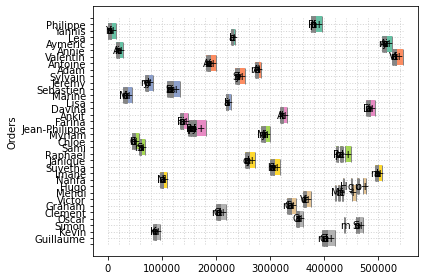

In [14]:
import docplex.cp.utils_visu as visu
if sol and visu.is_visu_enabled():
    visu.timeline(origin=0)
    visu.panel("Orders")
    for i in range(n):
        visu.sequence(O[i][0])
        for j in range(len(L[i])):
            visu.interval(sol.get_var_solution(letter[i][j]), i, L[i][j])
        visu.interval(sol.get_var_solution(assemble[i]), i, '+')
    visu.show()

# Extensions

We will consider several extensions of the problem to make it more realistic:
  * Availability of more than one jeweller:
    * Two master jewellers with the same skills
    * Two jewellers with different skills (e.g. master and apprentice, apprentice works slower)
  * Taking into account week-ends and vacations
    * Tasks can be suspended by breaks
    * Tasks cannot be suspended by breaks
  * Batching: several copies of the same letter can be produced in a single task
  * Setup times: switching the production from one letter to a different letter take some time
  * Inventories:
    * Inventory limit: limited space to store the letters between their production and the assembly task
    * Inventory cost

# Notes

[1] If you are interested in the making-of of this course, for the complexity of letters, I have been using the results of a script counting the number of pixels of the different letters provided here: https://gist.github.com/alexmic/8345076

